In [6]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

df = pd.read_csv("fiehnlib_4_classes.csv", index_col=[0])
#df.drop(columns="LG2-435", inplace=True)
r2_table = df.corr().apply(lambda x: x**2)
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]
def split(df, test_size=0.25, seed=0):
    np.random.seed(seed)
    train = pd.DataFrame()
    test = pd.DataFrame()
    ind = set(df.index)
    ind_train = []
    names = list(df.Name)
    while len(train)<=len(df)*(1-test_size):
        name = np.random.choice(names)
        names = remove_values_from_list(names, name)
        added = df[df.Name==name]
        ind_train.extend(list(added.index))
        train = pd.concat([train, added])
    test_ind = list(ind-set(ind_train))
    test = df.iloc[test_ind, :]
    X_train, X_test, y_train, y_test = train.loc[:, :"500"], test.loc[:, :"500"], train.TMS, test.TMS
    return X_train, X_test, y_train, y_test
train_test = [
    split(df,test_size=0.25,seed=i) for i in range(3)
]
def preprocessed_data(seed, n_features=None, n_pc=None, filtering=False):
    X_train, X_test, y_train, y_test = train_test[seed]
    train_index = X_train.index
    test_index = X_test.index
    if n_features:
        best_features = SelectKBest(k=n_features).fit(df.drop(columns=["TMS", "Name"]), df.TMS).get_feature_names_out()
        if filtering:
            best_features = uncorr_list(best_features, ["LG2-145"], 0.4)
        X_train, X_test = X_train[best_features], X_test[best_features]
    if n_pc:
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        pca = PCA()
        pca.fit(X_train)
        X_train = pd.DataFrame(
            pca.transform(X_train),
            index=train_index).iloc[:, :n_pc]
        X_test = pd.DataFrame(
            pca.transform(X_test),
            index=test_index).iloc[:, :n_pc]
    return X_train, X_test, y_train, y_test
def plot_conf_matrix(clf, n_features=None, n_pc=None, filtering=False):
    for seed in range(3):
        X_train, X_test, y_train, y_test = preprocessed_data(seed, n_features, n_pc, filtering)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1','actual 2', 'actual 3'], columns = ['predicted 0', 'predicted 1','predicted 2', 'predicted 3'])
        display(conf_matrix)
def simple_alg(X_train, X_test, y_train, y_test, df=df):
    df_alphas = dict()
    df_alphas["n_features"], df_alphas["best_alpha"], df_alphas[
        "cv_score"], df_alphas["train_score"], df_alphas[
            "test_score"] = [], [], [], [], []
    for n in range(1, 201,10):
        best_features = SelectKBest(k=n).fit(df.drop(columns=["TMS", "Name"]),
                                             df.TMS).get_feature_names_out()
        X_train_n, X_test_n = X_train[best_features], X_test[best_features]
        clf = DecisionTreeClassifier(random_state=0)
        path = clf.cost_complexity_pruning_path(X_train_n, y_train)
        ccp_alphas, impurities = path.ccp_alphas, path.impurities
        mean_acc, std = [], []
        for ccp_alpha in ccp_alphas:
            clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0)
            scores = cross_val_score(clf, X_train_n, y_train, cv=5)
            mean_acc.append(scores.mean())
        eva_df = pd.DataFrame({"alpha": ccp_alphas, "mean": mean_acc})
        eva_df = eva_df.sort_values(["mean"], ascending=False)
        best_alpha, cv_score = eva_df.iloc[0]
        best_tree = DecisionTreeClassifier(ccp_alpha=best_alpha,
                                           random_state=0).fit(
                                               X_train_n, y_train)
        train_score = best_tree.score(X_train_n, y_train)
        test_score = best_tree.score(X_test_n, y_test)
        df_alphas["n_features"].append(n)
        df_alphas["best_alpha"].append(best_alpha)
        df_alphas["cv_score"].append(cv_score)
        df_alphas["train_score"].append(train_score)
        df_alphas["test_score"].append(test_score)
    df_scores = pd.DataFrame(df_alphas)
    best_model = df_scores[abs(df_scores.cv_score -
                               df_scores.cv_score.max()) <= 0.003 *
                           5.5].head(1)
    return df_scores, best_model


def pca_alg(X_train, X_test, y_train, y_test, df=df, threshold=0.99):
    def pca_variance_threshold(pca, threshold):
        for i in range(1, len(pca.explained_variance_ratio_) + 1):
            if pca.explained_variance_ratio_[:i].sum() >= threshold:
                return i

    df_alphas = dict()
    df_alphas["n_features"], df_alphas["best_alpha"], df_alphas[
        "n_pc"], df_alphas["cv_score"], df_alphas["train_score"], df_alphas[
            "test_score"] = [], [], [], [], [], []
    for n in range(1, 201, 10):
        best_features = SelectKBest(k=n).fit(df.drop(columns=["TMS", "Name"]),
                                             df.TMS).get_feature_names_out()
        X_train_n, X_test_n = X_train[best_features], X_test[best_features]
        scaler = StandardScaler().fit(X_train_n)
        X_train_n = scaler.transform(X_train_n)
        X_test_n = scaler.transform(X_test_n)
        pca = PCA()
        pca.fit(X_train_n)
        X_train_n = pd.DataFrame(
            pca.transform(X_train_n),
            index=X_train.index).iloc[:, :pca_variance_threshold(pca, threshold)]
        X_test_n = pd.DataFrame(
            pca.transform(X_test_n),
            index=X_test.index).iloc[:, :pca_variance_threshold(pca, threshold)]
        clf = DecisionTreeClassifier(random_state=0)
        path = clf.cost_complexity_pruning_path(X_train_n, y_train)
        ccp_alphas, impurities = path.ccp_alphas, path.impurities
        mean_acc, std = [], []
        for ccp_alpha in ccp_alphas:
            clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0)
            scores = cross_val_score(clf, X_train_n, y_train, cv=5)
            mean_acc.append(scores.mean())
        eva_df = pd.DataFrame({"alpha": ccp_alphas, "mean": mean_acc})
        eva_df = eva_df.sort_values(["mean"], ascending=False)
        best_alpha, cv_score = eva_df.iloc[0]
        best_tree = DecisionTreeClassifier(ccp_alpha=best_alpha,
                                           random_state=0).fit(
                                               X_train_n, y_train)
        train_score = best_tree.score(X_train_n, y_train)
        test_score = best_tree.score(X_test_n, y_test)
        df_alphas["n_features"].append(n)
        df_alphas["n_pc"].append(pca_variance_threshold(pca, threshold))
        df_alphas["best_alpha"].append(best_alpha)
        df_alphas["cv_score"].append(cv_score)
        df_alphas["train_score"].append(train_score)
        df_alphas["test_score"].append(test_score)
    df_scores = pd.DataFrame(df_alphas)
    best_model = df_scores[abs(df_scores.cv_score -
                               df_scores.cv_score.max()) <= 0.003 *
                           5.5].head(1)
    return df_scores, best_model

def uncorr_list(features_to_choose, chosen_features, threshold):
        for viewed_feature in features_to_choose:
            r2_values = []
            for chosen_feature in chosen_features:
                r2_values.append(r2_table.loc[chosen_feature, viewed_feature])
            if all([x < threshold for x in r2_values]):
                chosen_features.append(viewed_feature)
        return chosen_features

def filter_alg(X_train, X_test, y_train, y_test, threshold=0.4, df=df):
    df_alphas = dict()
    df_alphas["n_features"], df_alphas["best_alpha"], df_alphas[
        "cv_score"], df_alphas["train_score"], df_alphas[
            "test_score"] = [], [], [], [], []
    for n in range(1, 201,10):
        best_features = SelectKBest(k=n).fit(df.drop(columns=["TMS", "Name"]),
                                             df.TMS).get_feature_names_out()
        best_features = uncorr_list(best_features, ["LG2-145"], threshold)
        X_train_n, X_test_n = X_train[best_features], X_test[best_features]
        clf = DecisionTreeClassifier(random_state=0)
        path = clf.cost_complexity_pruning_path(X_train_n, y_train)
        ccp_alphas, impurities = path.ccp_alphas, path.impurities
        mean_acc, std = [], []
        for ccp_alpha in ccp_alphas:
            clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0)
            scores = cross_val_score(clf, X_train_n, y_train, cv=5)
            mean_acc.append(scores.mean())
        eva_df = pd.DataFrame({"alpha": ccp_alphas, "mean": mean_acc})
        eva_df = eva_df.sort_values(["mean"], ascending=False)
        best_alpha, cv_score = eva_df.iloc[0]
        best_tree = DecisionTreeClassifier(ccp_alpha=best_alpha,
                                           random_state=0).fit(
                                               X_train_n, y_train)
        train_score = best_tree.score(X_train_n, y_train)
        test_score = best_tree.score(X_test_n, y_test)
        df_alphas["n_features"].append(n)
        df_alphas["best_alpha"].append(best_alpha)
        df_alphas["cv_score"].append(cv_score)
        df_alphas["train_score"].append(train_score)
        df_alphas["test_score"].append(test_score)
    df_scores = pd.DataFrame(df_alphas)
    best_model = df_scores[abs(df_scores.cv_score -
                               df_scores.cv_score.max()) <= 0.003 *
                           5.5].head(1)
    return df_scores, best_model
def lda_pca_alg(X_train, X_test, y_train, y_test, df=df):
    n_f=200
    def find_best_num(row, param):
        max_value = max(row)
        for i, value in enumerate(row):
            if abs(value-max_value)<=param*0.003:
                return i+1
    df_alphas = dict()
    ln = len(list(range(1,n_f+1,10)))
    df_alphas["n_features"] = list(range(1,n_f+1,10))
    total_scores = []
    total_test_scores = []
    total_train_scores = []
    for n in range(1,n_f+1,10):
        best_features = SelectKBest(k=n).fit(df.drop(columns=["TMS", "Name"]), df.TMS).get_feature_names_out()
        X_train_n, X_test_n = X_train[best_features], X_test[best_features]
        scaler = StandardScaler().fit(X_train_n)
        X_train_n = scaler.transform(X_train_n)
        X_test_n = scaler.transform(X_test_n)
        scores= []
        test_scores = []
        train_scores = []
        pca = PCA().fit(X_train_n)
        X_train_n = pd.DataFrame(pca.transform(X_train_n), index=X_train.index)
        X_test_n = pd.DataFrame(pca.transform(X_test_n), index=X_test.index)
        for k in range(0,n):
            X_train_k = X_train_n.loc[:, :k]
            X_test_k = X_test_n.loc[:, :k]
            LDA = LinearDiscriminantAnalysis().fit(X_train_k, y_train)
            score = cross_val_score(LinearDiscriminantAnalysis(), X_train_k, y_train)
            test_score = LDA.score(X_test_k, y_test)
            train_score = LDA.score(X_train_k, y_train)
            scores.append([score.mean(), k+1])
            test_scores.append([test_score, k+1])
            train_scores.append([train_score, k+1])
        total_scores.append([x[0] for x in scores]+[0 for _ in range(n_f-n)])
        total_test_scores.append([x[0] for x in test_scores]+[0 for _ in range(n_f-n)])
        total_train_scores.append([x[0] for x in train_scores]+[0 for _ in range(n_f-n)])                       
    best_num = [find_best_num(row, 5.5) for row in total_scores]
    indices = np.array(best_num)-1
    df_alphas["n_pc"] = best_num
    best_acc = [np.array(total_scores)[i, indices[i]] for i in range(ln)]
    best_train_acc = [np.array(total_train_scores)[i, indices[i]] for i in range(ln)]
    best_test_acc = [np.array(total_test_scores)[i, indices[i]] for i in range(ln)]
    df_alphas["cv_score"] = best_acc
    df_alphas["train_score"], df_alphas["test_score"] = best_train_acc, best_test_acc
    df_scores = pd.DataFrame(df_alphas)
    best_model = df_scores[abs(df_scores.cv_score -
                               df_scores.cv_score.max()) <= 0.003 *
                           5.5].head(1)
    return df_scores, best_model,total_scores

In [7]:
alg = simple_alg
name = alg.__name__
scores_and_results = [alg(*train_test[seed]) for seed in (0, 1, 2)]
results = [scores_and_results[seed][1] for seed in (0, 1, 2)]
results_1 = pd.DataFrame([results[i].iloc[0, :] for i in range(3)],
                       index=[0, 1, 2])
results_1.n_features = results_1.n_features.astype(int)
sns.set_theme()
fig_1, ax_1 = plt.subplots(1, 3, figsize=[14, 7])
for i in range(3):
    ax_1[i].set_title(f'seed {i}')
    sns.lineplot(ax=ax_1[i],
                 data=scores_and_results[i][0],
                 x="n_features",
                 y="cv_score",
                 label="cv_score",
                 legend=False)
    ax_1[i].set_xticks(range(0, 200, 20))
    ax_1[i].set_xlim(1, 200)
    ax_1[i].set_ylim(0.5,0.8)
    if i > 0:
        ax_1[i].set_ylabel("")
plt.xlabel("n_features")
fig_1.suptitle(f'Алгоритм: {name}')
plt.tight_layout()
plt.close()

In [8]:
alg = filter_alg
name = alg.__name__
scores_and_results = [alg(*train_test[seed]) for seed in (0, 1, 2)]
results = [scores_and_results[seed][1] for seed in (0, 1, 2)]
results_2 = pd.DataFrame([results[i].iloc[0, :] for i in range(3)],
                       index=[0, 1, 2])
results_2.n_features = results_2.n_features.astype(int)
sns.set_theme()
fig_2, ax_2 = plt.subplots(1, 3, figsize=[14, 7])
for i in range(3):
    ax_2[i].set_title(f'seed {i}')
    sns.lineplot(ax=ax_2[i],
                 data=scores_and_results[i][0],
                 x="n_features",
                 y="cv_score",
                 label="cv_score",
                 legend=False)
    ax_2[i].set_xticks(range(0, 200, 20))
    ax_2[i].set_xlim(1, 200)
    ax_2[i].set_ylim(0.5,0.8)
    if i > 0:
        ax_2[i].set_ylabel("")
plt.xlabel("n_features")
fig_2.suptitle(f'Алгоритм: {name}')
plt.tight_layout()
plt.close()

In [9]:
alg = pca_alg
name = alg.__name__
scores_and_results = [alg(*train_test[seed]) for seed in (0, 1, 2)]
results = [scores_and_results[seed][1] for seed in (0, 1, 2)]
results_3 = pd.DataFrame([results[i].iloc[0, :] for i in range(3)],
                       index=[0, 1, 2])
results_3.n_features = results_3.n_features.astype(int)
sns.set_theme()
fig_3, ax_3 = plt.subplots(1, 3, figsize=[14, 7])
for i in range(3):
    ax_3[i].set_title(f'seed {i}')
    sns.lineplot(ax=ax_3[i],
                 data=scores_and_results[i][0],
                 x="n_features",
                 y="cv_score",
                 label="cv_score",
                 legend=False)
    ax_3[i].set_xticks(range(0, 200, 20))
    ax_3[i].set_xlim(1, 200)
    ax_3[i].set_ylim(0.5,0.8)
    if i > 0:
        ax_3[i].set_ylabel("")
plt.xlabel("n_features")
fig_3.suptitle(f'Алгоритм: {name}')
plt.tight_layout()
plt.close()

In [10]:
alg = lda_pca_alg
name = alg.__name__
scores_and_results = [alg(*train_test[seed]) for seed in (0, 1, 2)]
results = [scores_and_results[seed][1] for seed in (0, 1, 2)]
results_4 = pd.DataFrame([results[i].iloc[0, :] for i in range(3)],
                       index=[0, 1, 2])
results_4.n_features = results_4.n_features.astype(int)
sns.set_theme()
fig_4, ax_4 = plt.subplots(1, 3, figsize=[14, 7])
for i in range(3):
    ax_4[i].set_title(f'seed {i}')
    sns.lineplot(ax=ax_4[i],
                 data=scores_and_results[i][0],
                 x="n_features",
                 y="cv_score",
                 label="cv_score",
                 legend=False)
    ax_4[i].set_xticks(range(0, 200, 20))
    ax_4[i].set_xlim(1, 200)
    ax_4[i].set_ylim(0.5,0.8)
    if i > 0:
        ax_4[i].set_ylabel("")
plt.xlabel("n_features")
fig_4.suptitle(f'Алгоритм: {name}')
plt.tight_layout()
plt.close()

# Результаты работы алгоритма simple_alg

## Кросс-валидация:

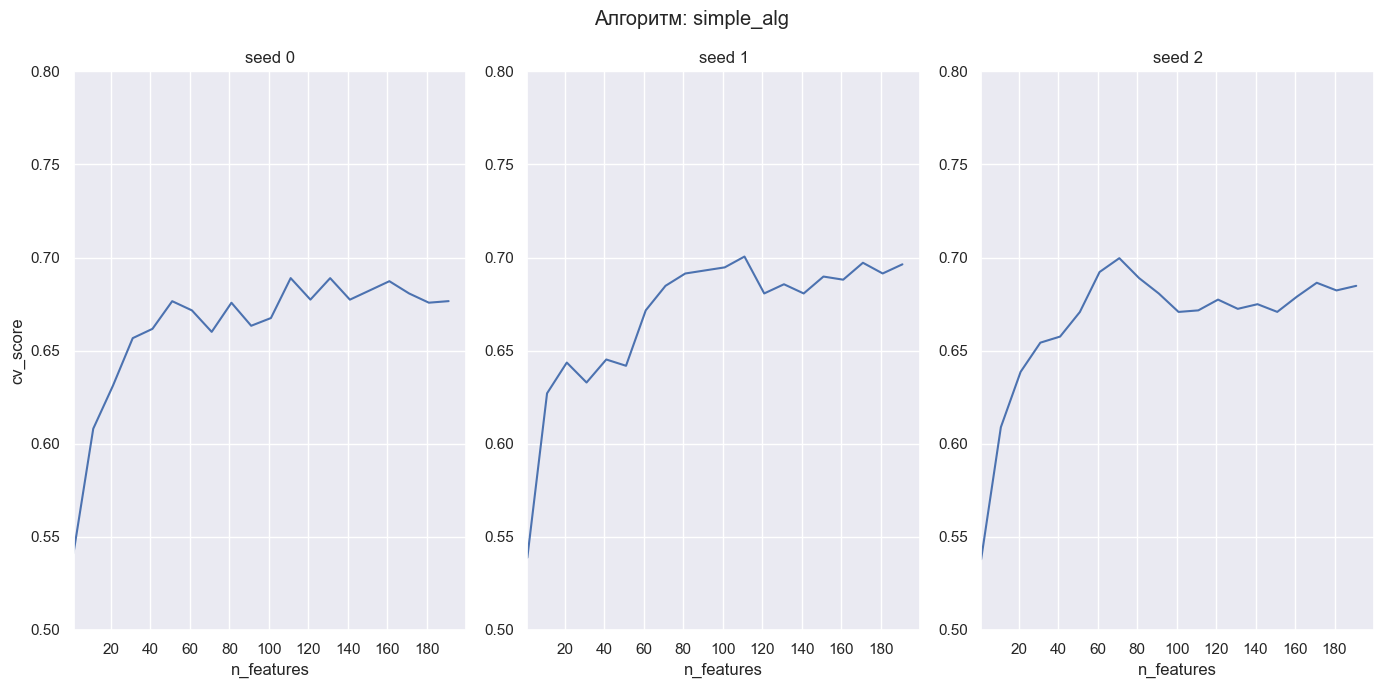

In [11]:
fig_1

## Подбор лучшей модели: 

In [12]:
print(results_1)

   n_features  best_alpha  cv_score  train_score  test_score
0          51    0.003004  0.676560     0.825083    0.662531
1          71    0.004091  0.684821     0.801980    0.707196
2          61    0.002845  0.692232     0.850660    0.702233


In [13]:
plot_conf_matrix(DecisionTreeClassifier(ccp_alpha=0.004091, random_state=0), n_features=71)

,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,47,22,7,0
actual 1,19,48,13,1
actual 2,3,8,75,12
actual 3,1,2,31,114


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,34,16,5,1
actual 1,15,50,13,0
actual 2,12,8,85,22
actual 3,2,3,21,116


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,55,17,6,0
actual 1,18,45,8,2
actual 2,0,9,72,30
actual 3,0,5,29,107


# Результаты работы алгоритма filter_alg

## Кросс-валидация: 

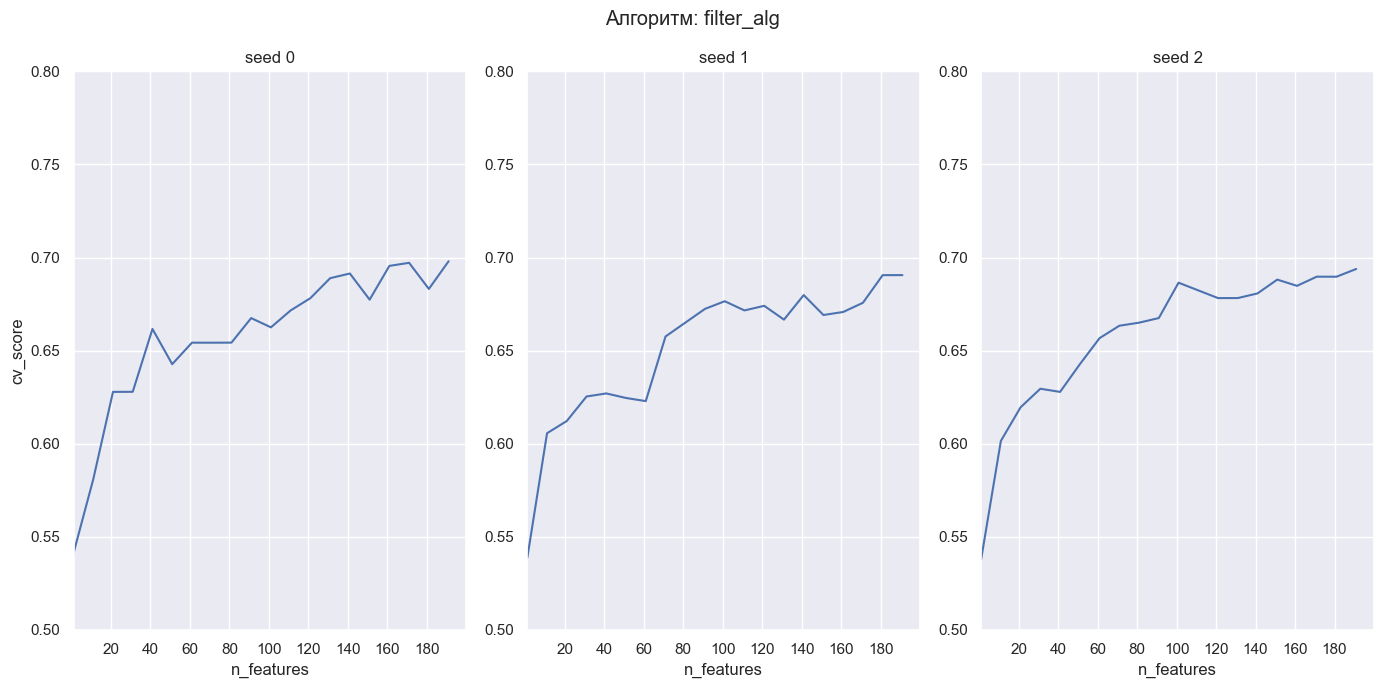

In [14]:
fig_2

## Подбор лучшей модели: 

In [15]:
print(results_2)

   n_features  best_alpha  cv_score  train_score  test_score
0         131    0.004332  0.688916     0.771452    0.697270
1         101    0.002448  0.676540     0.892739    0.692308
2         101    0.002537  0.686495     0.891914    0.672457


In [16]:
plot_conf_matrix(DecisionTreeClassifier(ccp_alpha=0.002448, random_state=0), n_features=101, filtering=True)

,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,46,21,6,3
actual 1,18,48,11,4
actual 2,5,7,55,31
actual 3,1,0,33,114


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,32,15,7,2
actual 1,13,53,8,4
actual 2,2,17,81,27
actual 3,2,4,21,115


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,44,20,11,3
actual 1,14,46,9,4
actual 2,7,10,71,23
actual 3,2,3,24,112


# Результаты работы алгоритма pca_alg

## Кросс-валидация: 

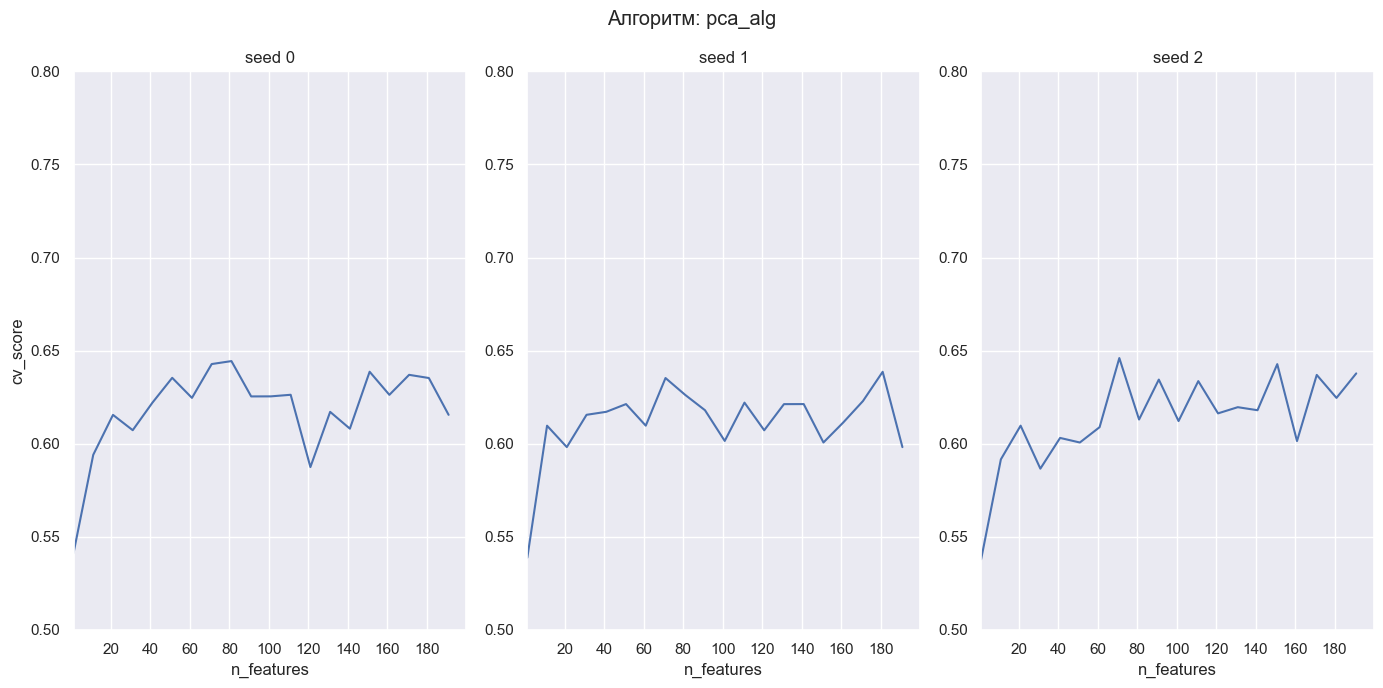

In [17]:
fig_3

## Подбор лучшей модели: 

In [18]:
print(results_3)

   n_features  best_alpha  n_pc  cv_score  train_score  test_score
0          51    0.002000  42.0  0.635408     0.940594    0.630273
1          71    0.003186  58.0  0.635292     0.864686    0.627792
2          71    0.004463  58.0  0.646019     0.775578    0.607940


In [19]:
plot_conf_matrix(DecisionTreeClassifier(ccp_alpha=0.003186, random_state=0), n_features=71, n_pc=58)

,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,39,27,5,5
actual 1,22,47,7,5
actual 2,5,10,48,35
actual 3,2,2,34,110


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,34,14,3,5
actual 1,13,48,11,6
actual 2,5,14,58,50
actual 3,1,4,24,113


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,43,25,9,1
actual 1,19,40,13,1
actual 2,9,6,64,32
actual 3,3,3,32,103


# Результаты работы алгоритма lda_pca_alg

## Кросс-валидация: 

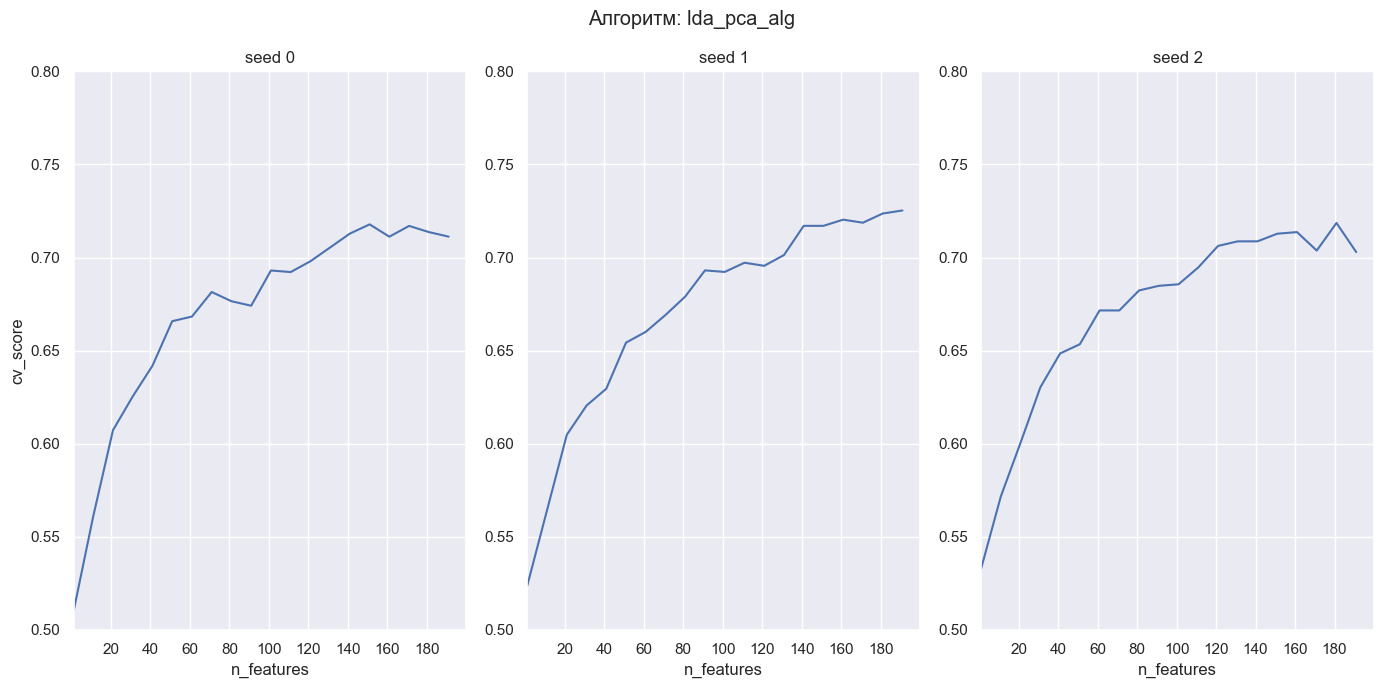

In [20]:
fig_4

## Подбор лучшей модели: 

In [21]:
print(results_4)

   n_features   n_pc  cv_score  train_score  test_score
0         131  110.0  0.705425     0.783003    0.739454
1         141  120.0  0.717019     0.800330    0.722084
2         121   90.0  0.706237     0.771452    0.702233


In [22]:
plot_conf_matrix(LinearDiscriminantAnalysis(), n_features=131, n_pc=110)

,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,46,23,6,1
actual 1,12,60,8,1
actual 2,4,9,68,17
actual 3,2,3,19,124


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,31,20,3,2
actual 1,17,49,8,4
actual 2,3,12,90,22
actual 3,0,3,16,123


,predicted 0,predicted 1,predicted 2,predicted 3
actual 0,43,31,3,1
actual 1,13,50,7,3
actual 2,3,8,78,22
actual 3,0,6,21,114
